## Regression with Boston House Price Dataset

We’ll attempt to predict the median price of homes in a given Boston
suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.

The dataset has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the
input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1, while others take values between 1 and 12, others between 0 and 100, and so on.


In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 2us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

#### Preparing the data
It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
for dealing with such data is to do feature-wise normalization: for each feature in the
input data (a column in the input data matrix), we subtract the mean of the feature
and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. This is easily done in NumPy.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean

In [7]:
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

#### Building your model
Because so few samples are available, we’ll use a very small model with two intermediate layers, each with 64 units. In general, the less training data you have, the worse
overfitting will be, and using a small model is one way to mitigate overfitting

In [9]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

The model ends with a single unit and no activation (it will be a linear layer). This is a
typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer,
the model could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the model is free to learn to predict values in any range.

#### Validating your approach using K-fold validation

It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating
on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. I

In [10]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [13]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0) #Trains the model(in silent mode, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [15]:
all_scores

[2.083127498626709, 2.4419445991516113, 2.5394186973571777, 2.4903769493103027]

In [16]:
np.mean(all_scores)

2.38871693611145

The different runs do indeed show rather different validation scores, from 2.0 to 2.5.
The average (2.4) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, we’re off by $$2,400 on average,
which is significant considering that the prices range from $10,000 to $50,000.
 Let’s try training the model a bit longer: 500 epochs. To keep a record of how well
the model does at each epoch, we’ll modify the training loop to save the per-epoch
validation score log for each fold.

In [17]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]

    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [18]:
# We can then compute the average of the per-epoch MAE scores for all folds.
average_mae_history = [
 np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

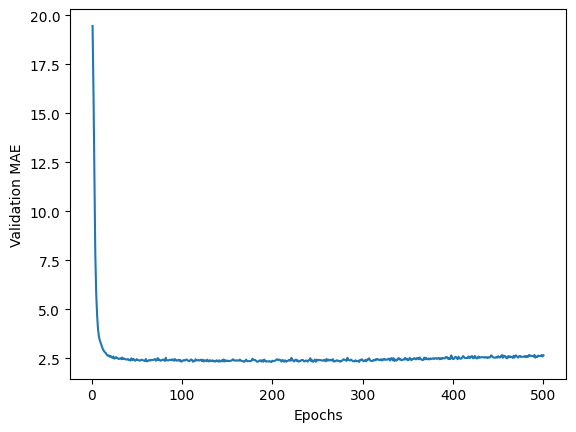

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE
for the first few epochs is dramatically higher than the values that follow. Let’s omit
the first 10 data points, which are on a different scale than the rest of the curve

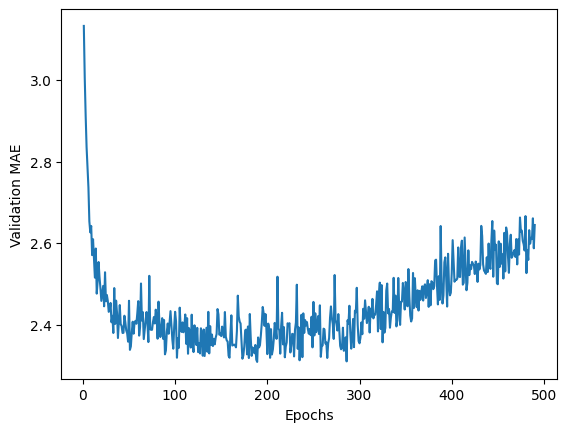

In [22]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As you can see, validation MAE stops improving significantly after
260-280 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.
 Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the intermediate layers), you can
train a final production model on all of the training data, with the best parameters,
and then look at its performance on the test data.

In [25]:
model = build_model()  #Gets a fresh, compiled model
model.fit(train_data, train_targets, epochs=280, batch_size=16, verbose=0)  #Trains it on the entirety of the data
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 13.6458 - mae: 2.3237


In [26]:
#Here’s the final result:
test_mae_score

2.3237109184265137

We’re still off by a bit under $2,400. It’s an improvement! Just like with the two previous tasks, you can try varying the number of layers in the model, or the number of
units per layer, to see if you can squeeze out a lower test error.

Now, with this scalar regression model, predict() returns the model’s guess for the sample’s price in
thousands of dollars:

In [27]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 7ms/step


array([8.781573], dtype=float32)

The first house in the test set is predicted to have a price of about $8800.